# Khai báo thư viện & thiết lập ban đầu

In [ ]:
import os
import numpy as np
import cv2
from sklearn.metrics import f1_score
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
np.random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/fc-cnn-assignment.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/VietAI-Assignment3-550.jpg  
  inflating: images/images/VietAI-Assignment3-5500.jpg  
  inflating: images/images/VietAI-Assignment3-5501.jpg  
  inflating: images/images/VietAI-Assignment3-5502.jpg  
  inflating: images/images/VietAI-Assignment3-5503.jpg  
  inflating: images/images/VietAI-Assignment3-5504.jpg  
  inflating: images/images/VietAI-Assignment3-5505.jpg  
  inflating: images/images/VietAI-Assignment3-5506.jpg  
  inflating: images/images/VietAI-Assignment3-5507.jpg  
  inflating: images/images/VietAI-Assignment3-5508.jpg  
  inflating: images/images/VietAI-Assignment3-5509.jpg  
  inflating: images/images/VietAI-Assignment3-551.jpg  
  inflating: images/images/VietAI-Assignment3-5510.jpg  
  inflating: images/images/VietAI-Assignment3-5511.jpg  
  inflating: images/images/VietAI-Assignment3-5512.jpg  
  inflating: images/images/VietAI-Assignment3-5513.jpg  
  inflating: images/images/VietAI-Assig

In [ ]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,image,label
0,VietAI-Assignment3-1.jpg,7
1,VietAI-Assignment3-100.jpg,2
2,VietAI-Assignment3-10000.jpg,1
3,VietAI-Assignment3-10001.jpg,2
4,VietAI-Assignment3-10002.jpg,2


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8234 entries, 0 to 8233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   8234 non-null   object
 1   label   8234 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 128.8+ KB


# DataLoader

In [ ]:
class Dataset:
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.w = 224
        self.h = 224
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        image = cv2.imread(self.data[i])
        image = cv2.resize(image, (self.w, self.h))
        image = np.array(image, dtype='float32')/255
        label = self.label[i]  # Chỉnh sửa: Lấy nhãn tương ứng với ảnh
        return image, label


In [ ]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = min((i + 1) * self.batch_size, len(self.dataset))  # Chỉnh sửa: Xử lý chỉ mục kết thúc
        data = [self.dataset[j] for j in range(start, stop)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    def __len__(self):
        return (self.size + self.batch_size - 1) // self.batch_size  # Chỉnh sửa: Tính toán số lượng batch

In [ ]:
# List các đường dẫn file cho việc huấn luyện
train_files = [os.path.join("/content/images/images", file) for file in train_df.image]
# List các nhãn
train_y = train_df.label

In [ ]:
num_classes = len(np.unique(train_y))
y_ohe = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)

In [ ]:
x_train, x_valid, y_train_ohe, y_valid_ohe = train_test_split(train_files, y_ohe, test_size=0.25)

In [ ]:
train_dataset = Dataset(x_train, y_train_ohe)
valid_dataset = Dataset(x_valid,y_valid_ohe)
train_loader = Dataloader(train_dataset, 64, len(train_dataset))
valid_loader = Dataloader(valid_dataset, 64, len(valid_dataset))

# Thiết lập mô hình CNN

In [ ]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel, strides, padding):
        '''
        Khởi tạo Convolution Block với các tham số đầu vào

        Parameters
        ----------
        filters: int
            số lượng filter
        kernel: int
            kích thước kernel
        strides: int
            stride của convolution layer
        padding: str
            Loại padding của convolution layer

        '''
        super(ConvBlock, self).__init__()
        ## TODO 2
        ### START CODE HERE
        self.cnn = tf.keras.layers.Conv2D(filters, kernel, strides=strides,  padding=padding, activation = 'relu')
        ### END CODE HERE
    def call(self, inputs):
        '''
        Hàm này sẽ được gọi trong quá trình forwarding của mạng

        Parameters
        ----------
        inputs: tensor đầu vào

        Returns
        -------
        tensor
            giá trị đầu ra của mạng
        '''
        ## TODO 3
        ### START CODE HERE
        x = self.cnn(inputs)
        ## END CODE HERE
        return x

**Alex_net**

In [ ]:
class Alex_net(tf.keras.Model):
    def __init__(self, num_classes):
        super(Alex_net, self).__init__()
        ## TODO 4
        ### START CODE HERE
        self.conv1 =  ConvBlock(96,(11,11),4,'same')
        self.conv2 =  ConvBlock(256,(5,5),2,'same')
        self.conv3 =  ConvBlock(384,(3,3),1,'same')
        self.conv4 =  ConvBlock(384,(3,3),1,'same')
        self.conv5 =  ConvBlock(256,(3,3),1,'same')
        ### END CODE HERE
        ## TODO 5
        ### START CODE HERE
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=2)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(4096, activation = 'relu')
        self.dropout1 = tf.keras.layers.Dropout(0.8)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ### END CODE HERE

    def call(self, inputs):
        ## TODO 6
        x = inputs
        print(x.shape)
        ### START CODE HERE
        x = self.conv1(x)
        x= self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x=self.pool3(x)
        ### END CODE HERE
        ## TODO 7
        ### START CODE HERE
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        ### END CODE HERE
        return x

**Đào tạo Alexnet**

In [ ]:
device =  '/gpu:0'
import tensorflow
with tf.device(device):
    # Khởi tạo model
    model = Alex_net(num_classes)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Huấn luyện
    history=model.fit(train_loader, validation_data=valid_loader, epochs=50, verbose=1)
    model.save('my_model', save_format='tf')

(64, 224, 224, 3)
Epoch 1/50
(None, None, None, None)
(None, None, None, None)
97/97 [==============================] - 52s 463ms/step - loss: 2.2966 - accuracy: 0.2215 - val_loss: 2.1473 - val_accuracy: 0.2865
Epoch 2/50
97/97 [==============================] - 45s 463ms/step - loss: 2.0878 - accuracy: 0.2829 - val_loss: 2.1815 - val_accuracy: 0.2506
Epoch 3/50
97/97 [==============================] - 43s 439ms/step - loss: 1.9751 - accuracy: 0.3203 - val_loss: 1.9219 - val_accuracy: 0.3623
Epoch 4/50
97/97 [==============================] - 43s 447ms/step - loss: 1.8080 - accuracy: 0.3984 - val_loss: 1.7150 - val_accuracy: 0.4250
Epoch 5/50
97/97 [==============================] - 46s 477ms/step - loss: 1.6353 - accuracy: 0.4594 - val_loss: 1.5933 - val_accuracy: 0.4721
Epoch 6/50
97/97 [==============================] - 43s 440ms/step - loss: 1.5023 - accuracy: 0.5082 - val_loss: 1.5376 - val_accuracy: 0.4896
Epoch 7/50
97/97 [==============================] - 52s 541ms/step - loss:

**Đánh giá Alexnet**

0.6391451954841614


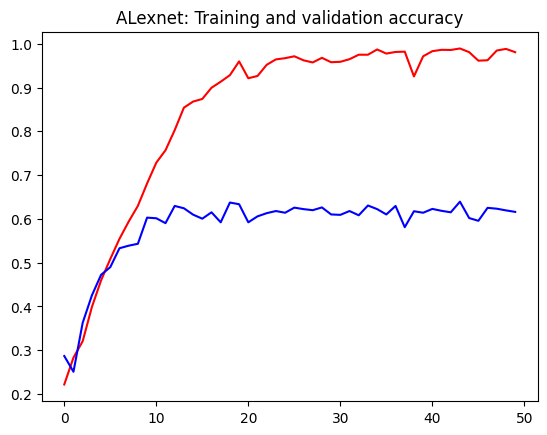

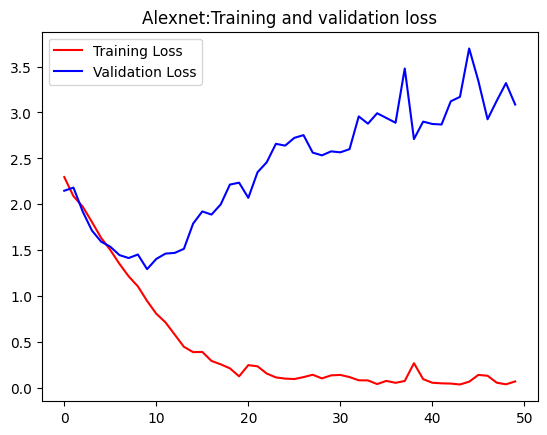

In [ ]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
print(max(val_acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('ALexnet: Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Alexnet:Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = Alex_net(num_classes)
dummy_x = tf.zeros((1, 224, 224, 3))
model._set_inputs(dummy_x)
loaded_model = tf.keras.models.load_model('my_model')
print("Model đã được load")

Model đã được load


**Tính F1 score**



(224, 224, 3)
1/1 [==============================] - 0s 144ms/step
(224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(224, 224, 3)
1/1 [==============================] - 0s 19ms/step
(224, 224, 3)
1/1 [==============================] - 0s 21ms/step
(224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(224, 224, 3)
1/1 [==============================] - 0s 19ms/step
(224, 224, 3)
1/1 [==============================] - 0s 19ms/step
(224, 224, 3)
1/1 [==============================] - 0s 21ms/step
(224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(224, 224, 3)
1/1 [==============================] - 0s 23ms/step
(224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(224, 224, 3)
1/1 [==============================] - 0s 22ms/step
(224, 224, 3)
1/1 [==============================] - 0s 19ms/step
(224, 224, 3)
1/1 [==============================] - 0s 19ms/step
(224, 224

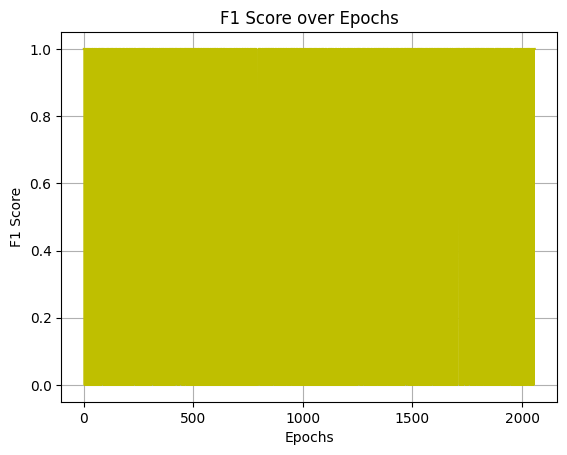

In [ ]:
y=0
f1=[]
for i in x_valid:
  image = cv2.imread(i)
  image= cv2.resize(image,(224,224))
  print(image.shape)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.expand_dims(image, axis=0)
  pred = loaded_model.predict(image)
  pred_labels = np.argmax(pred, axis=1)
  y_pre_test = tf.keras.utils.to_categorical(pred_labels, num_classes=11)
  f1.append(f1_score(y_pre_test.squeeze(),np.array(y_valid_ohe[y])))
  y=y+1

In [ ]:
f1=np.mean(f1)
print(f"f1 Score:{f1}")

**Lenet-05**

In [ ]:
class Lenet05(tf.keras.Model):
    def __init__(self, num_classes):
        super(Lenet05, self).__init__()
        ## TODO 4
        ### START CODE HERE
        self.conv1 =  ConvBlock(6,(5,5),1,'same')
        self.conv2 =  ConvBlock(16,(5,5),2,'same')
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=2)
        self.pool2 = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=2)
        ### END CODE HERE

        ## TODO 5
        ### START CODE HERE
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(120, activation = 'relu')
        self.fc2 = tf.keras.layers.Dense(84, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(num_classes, activation = 'softmax')
        ### END CODE HERE

    def call(self, inputs):

        ## TODO 6
        x = inputs
        ### START CODE HERE
        x = self.conv1(x)
        x= self.pool1(x)
        x = self.conv2(x)
        x= self.pool2(x)
        ### END CODE HERE

        ## TODO 7
        ### START CODE HERE
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        ### END CODE HERE
        return x

**Đào tạo Lenet**

In [ ]:
device =  '/gpu:0'
import tensorflow
with tf.device(device):
    # Khởi tạo model
    model2 = Lenet05(num_classes)
    # Compile model
    model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Huấn luyện
    history2=model2.fit(train_loader, validation_data=valid_loader, epochs=50, verbose=1)
    model2.save('my_model', save_format='tf')

Epoch 1/50
97/97 [==============================] - 47s 440ms/step - loss: 2.0893 - accuracy: 0.2853 - val_loss: 1.9386 - val_accuracy: 0.3458
Epoch 2/50
97/97 [==============================] - 40s 410ms/step - loss: 1.7768 - accuracy: 0.3968 - val_loss: 1.7701 - val_accuracy: 0.4031
Epoch 3/50
97/97 [==============================] - 41s 418ms/step - loss: 1.5034 - accuracy: 0.5051 - val_loss: 1.6033 - val_accuracy: 0.4735
Epoch 4/50
97/97 [==============================] - 52s 534ms/step - loss: 1.2362 - accuracy: 0.5982 - val_loss: 1.4207 - val_accuracy: 0.5488
Epoch 5/50
97/97 [==============================] - 43s 447ms/step - loss: 1.0090 - accuracy: 0.6706 - val_loss: 1.3856 - val_accuracy: 0.5712
Epoch 6/50
97/97 [==============================] - 39s 408ms/step - loss: 0.8097 - accuracy: 0.7365 - val_loss: 1.4049 - val_accuracy: 0.5648
Epoch 7/50
97/97 [==============================] - 41s 425ms/step - loss: 0.6236 - accuracy: 0.8076 - val_loss: 1.4298 - val_accuracy: 0.5852

**Đánh giá Lenet05**

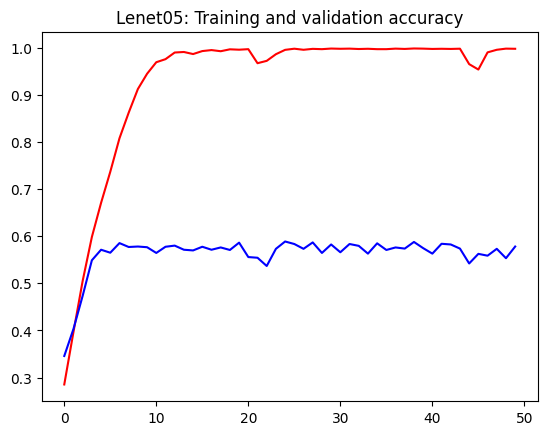

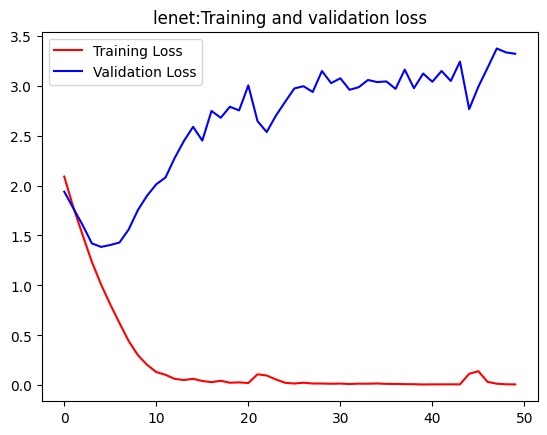

In [ ]:
import matplotlib.pyplot as plt
# Plot the model results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Lenet05: Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('lenet:Training and validation loss')
plt.legend()
plt.show()